# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

In [10]:
# import releavant packages 
import numpy as np
from photutils.datasets import make_4gaussians_image
from photutils import data_properties, EllipticalAperture
from astropy.stats import sigma_clipped_stats
import astropy.units as u
import matplotlib.pyplot as plt

In /Users/jhartke/.matplotlib/stylelib/presentation.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
Duplicate key in file '/Users/jhartke/.matplotlib/stylelib/sansserif.mplstyle' line #16.
In /Users/jhartke/.matplotlib/stylelib/publication.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
Duplicate key in file '/Users/jhartke/.matplotlib/stylelib/sansserif_proposal.mplstyle' line #16.


Create a fake cutout image and do some basic image statistics:

In [9]:
data = make_4gaussians_image()[43:79, 76:104]
mean, median, std = sigma_clipped_stats(data, sigma=3.0)

Text(0, 0.5, 'Y [pix]')

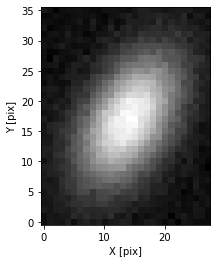

In [16]:
# image inspection
plt.imshow(data_sub, origin='lower', cmap='gray')
plt.xlabel('X [pix]')
plt.ylabel('Y [pix]')

Background subtraction

In [17]:
data_sub = data - median

Calculate the properties of the source in the cutout image

In [20]:
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
print(tbl)

 id     xcentroid      ... semiminor_axis_sigma    orientation   
           pix         ...         pix                 deg       
--- ------------------ ... -------------------- -----------------
  1 14.022509050180975 ...   3.6977761870218986 60.12830487529361


Define an isophotal ellipse from the measured morphological properties of the source:

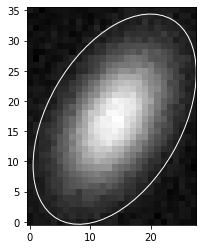

In [32]:
position = (cat.xcentroid.value, cat.ycentroid.value)
r = 3.0  # approximate isophotal extent
a = cat.semimajor_axis_sigma.value * r
b = cat.semiminor_axis_sigma.value * r
theta = cat.orientation.to(u.rad).value
apertures = EllipticalAperture(position, a, b, theta=theta)
plt.imshow(data_sub, origin='lower', cmap='gray')
apertures.plot(color='w')

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [37]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties

Again, we start from creating a simulated galaxy image.

In [40]:
g = Gaussian2D(amplitude=100., 
               x_mean=75, 
               y_mean=75, 
               x_stddev=20, 
               y_stddev=12, 
               theta=40.*np.pi/180.)
ny = nx = 150 # image dimensions in pixels
y, x = np.mgrid[0:ny, 0:nx]
noise = make_noise_image((ny, nx), distribution='gaussian', mean=0.,
                         stddev=2., random_state=12345)
data = g(x, y) + noise

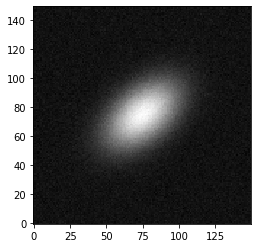

In [41]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower')

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [79]:
# image statistics 
mean, median, std = sigma_clipped_stats(data, sigma=3.0)
# subract background
data_sub = data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=np.deg2rad(tbl['orientation'][0].value),
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

5.533027328491555

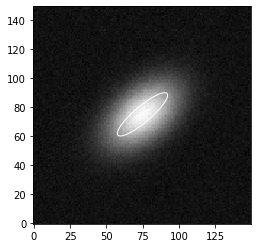

In [82]:
# how does it look?
plt.imshow(data_sub, cmap='gray', origin='lower')
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(1 - geometry.eps),
                          theta=geometry.pa)
aper.plot(color='white')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [84]:
ellipse = Ellipse(data, geometry)
isolist = ellipse.fit_image()

In [92]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_err,grad_rerr,x0,x0_err,y0,y0_err,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,102.23462791377399,0.0,0.0,0.0,0.0,0.0,0.0,None,None,74.06152395412352,0.0,74.88651126602444,0.0,1,0,0,0
0.539767161963036,101.20112998668097,0.02809849053879754,0.1518512052279728,0.02018885675254694,9.664830067729296,4.384648252077141,-2.3624442492739073,0.7445473650537846,0.3151597610325068,74.06152395412352,0.006380917722352074,74.88651126602444,0.0058123173204985175,13,0,10,0
0.5937438781593396,101.08350414163246,0.027782373185953998,0.15656919423767204,0.0185114212287344,10.670613853200635,3.9351273757384813,-2.2939088919511748,0.6678664003621773,0.29114774466657095,74.06435328698181,0.006573272540609748,74.87367173583328,0.005890675008199462,13,0,10,0
0.6531182659752736,100.9591963449631,0.027164206458125527,0.16216681588470286,0.017951826569853484,11.752787533634935,3.4793733503742788,-2.217633008608211,0.5937775317332047,0.2677528380161784,74.0664589081951,0.006690410100764276,74.85944092937491,0.005946614157528748,13,0,10,0
0.718430092572801,100.82915229317395,0.026185862969342215,0.16911217214295385,0.0153595393065369,13.052200460733022,3.024021810171487,-2.1327520772225075,0.5220802629096514,0.24479182014890302,74.06739519089818,0.006611927895558239,74.84324580725837,0.005866867988791166,13,0,10,0
0.7902731018300811,100.69464972798666,0.02488645097952119,0.17789208152518732,0.013735340217110212,14.597562750492774,2.5814586158091197,-2.0387688857011477,0.4558856912729549,0.22360832288068416,74.06677912767692,0.006514038667279141,74.82502778153287,0.005823161379162695,13,0,10,0
0.8693004120130893,100.55746520044957,0.02338839887450649,0.18890484983014783,0.012231738929548121,16.39961763335865,2.1798096293263685,-1.9289968816453866,0.40096830364235647,0.2078636349584663,74.06381343495997,0.006474894208280533,74.8043668216579,0.005729024363948687,13,0,10,0
0.9562304532143983,100.42171597764602,0.022014167850809892,0.203845970667469,0.012139892010576697,18.82173761117928,2.023305177719583,-1.657036953100012,0.4106498735463672,0.24782179587372305,74.05740046794772,0.007662010753088587,74.78072012729619,0.006283175976559959,13,0,10,0


Text(0, 0.5, 'x0')

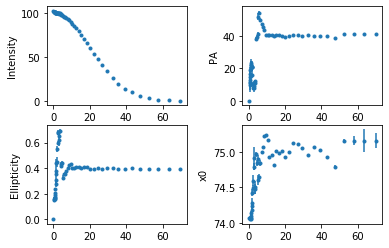

In [109]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
ax3.set_ylabel('Ellipticity')
ax4 = fig.add_subplot(224, sharex=ax1)
ax4.errorbar(tab['sma'], tab['x0'],
             yerr=tab['x0_err'],
             fmt='.')
ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [111]:
model_image = build_ellipse_model(data.shape, isolist)
residual = data - model_image

Text(0.5, 1.0, 'Residual')

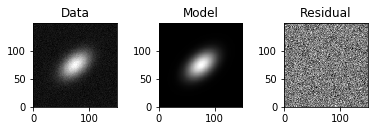

In [117]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(data, cmap='gray', origin='lower')
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower')
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower')
ax3.set_title('Residual')

In [122]:
aper = EllipticalAperture(positions=(tab['x0'][1:], tab['y0'][1:]), 
                          a=tab['sma'][1:],
                          b=tab['sma'][1:]*(1 - tab['ellipticity'][1:]),
                          theta=tab['pa'][1:])

ValueError: a must be a positive scalar

0.539767161963036
0.5937438781593396
0.6531182659752736
0.718430092572801
0.7902731018300811
0.8693004120130893
0.9562304532143983
1.051853498535838
1.157038848389422
1.2727427332283643
1.4000170065512008
